In [1]:
# Reference: https://towardsdatascience.com/transfer-learning-for-image-classification-using-keras-c47ccf09c8c8
# Reference: https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38
import os
import numpy as np
np.random.seed(251)
os.environ['PYTHONHASHSEED']=str(251)
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
project_path = r'D:\UCBerkeley\CourseWork\202001\W251\Homework\Project'
dir_openpose = 'openpose_output'
dir_train = 'NEW4_image_transfer_trial3'
dir_test = 'NEW4_manual_optical_flow_output_trial3'
model_name = 'ResNet50_model_weights_NEW4_trial3.h5'

TRAIN_DIR = os.path.join(project_path, dir_openpose, dir_train)
class_list = ['AGAIN', 'ALL', 'AWKWARD', 'BASEBALL', 'BEHAVIOR', 'CAN', 'CHAT', 'CHEAP', 
              'CHEAT', 'CHURCH', 'COAT', 'CONFLICT', 'COURT', 'DEPOSIT', 'DEPRESS', 
              'DOCTOR', 'DRESS', 'ENOUGH', 'NEG']

HEIGHT = 300
WIDTH = 300

BATCH_SIZE = 8
NUM_EPOCHS = 10
num_train_images = len([f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                        if 'train' in f])
print(num_train_images)

1155


In [6]:
# Reference: https://keras.io/preprocessing/image/
# Reference: https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
train_datagen =  ImageDataGenerator(
    preprocessing_function=preprocess_input,
    # Below are the parameters used for crop
    # zoom_range=[0.8, 1.2], 
    # width_shift_range=[-50,50]
    # Below are the parameters used for no crop
    zoom_range=[0.7, 1.3], 
    # width shift means up and down
    width_shift_range=0.2,
    height_shift_range = 0.2
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)

base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))
base_output = base_model.layers[-1].output
base_output = Flatten()(base_output)
base_model = Model(base_model.input, output=base_output)

# for layer in base_model.layers:
#     layer.trainable = False
    
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name in ['res5c_branch2c']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
layers = [(layer, layer.name, layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)

Found 1155 images belonging to 19 classes.


C:\Users\Angela\Anaconda3\envs\w251_project3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
C:\Users\Angela\Anaconda3\envs\w251_project3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`


,Layer Type,Layer Name,Layer Trainable
166,<keras.layers.normalization.BatchNormalization...,bn5c_branch2a,False
167,<keras.layers.core.Activation object at 0x0000...,activation_194,False
168,<keras.layers.convolutional.Conv2D object at 0...,res5c_branch2b,False
169,<keras.layers.normalization.BatchNormalization...,bn5c_branch2b,False
170,<keras.layers.core.Activation object at 0x0000...,activation_195,False
171,<keras.layers.convolutional.Conv2D object at 0...,res5c_branch2c,True
172,<keras.layers.normalization.BatchNormalization...,bn5c_branch2c,True
173,<keras.layers.merge.Add object at 0x00000231A7...,add_64,True
174,<keras.layers.core.Activation object at 0x0000...,activation_196,True
175,<keras.layers.core.Flatten object at 0x0000023...,flatten_4,True


In [7]:
base_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 306, 306, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 150, 150, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [8]:
model = Sequential()
model.add(base_model)
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(class_list), activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.00001),
              metrics=['accuracy'])
model.summary()

history = model.fit_generator(train_generator, epochs=NUM_EPOCHS, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Model)              (None, 204800)            23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 19)                9747      
Total params: 128,718,227
Trainable params: 106,185,235
Non-trainable params: 22,532,992
_______________________________

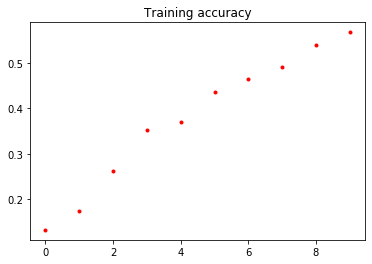

In [9]:
# Plot the training and validation loss + accuracy
def plot_training(history):
    acc = history.history['accuracy']
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r.')
    plt.title('Training accuracy')
    plt.show()

plot_training(history)


In [10]:
from keras.preprocessing import image
import numpy as np
from keras.models import load_model
# model_saved = load_model(os.path.join(project_path, model_name))
# model_saved = finetune_model
model_saved = model
def conv_index_to_vocab(ind):
    temp_dict = dict(enumerate(class_list))
    return temp_dict[ind]
def conv_vocab_to_index(vocab):
    temp_dict = dict(zip(class_list,range(len(class_list))))
    return temp_dict[vocab]

print(conv_index_to_vocab(0))
print(conv_vocab_to_index('NEG'))

AGAIN
18


In [11]:
count = 0
test_files_lst = [f for f in os.listdir(os.path.join(project_path, dir_openpose, dir_test)) 
                  if 'test' in f and 'sim0' in f]
for file in test_files_lst:
    img = image.load_img(os.path.join(project_path,dir_openpose, dir_test,file), target_size=(300, 300))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    y_pred = model_saved.predict(x)
    print('-----------------')
    print('Actual: ', file.split('_')[1])
    print('Prediction: ', conv_index_to_vocab(np.argmax(y_pred)))
    if file.split('_')[1] == conv_index_to_vocab(np.argmax(y_pred)):
        count += 1 

-----------------
Actual:  AGAIN
Prediction:  ALL
-----------------
Actual:  ALL
Prediction:  COURT
-----------------
Actual:  AWKWARD
Prediction:  AWKWARD
-----------------
Actual:  BASEBALL
Prediction:  CAN
-----------------
Actual:  BEHAVIOR
Prediction:  BEHAVIOR
-----------------
Actual:  CAN
Prediction:  CAN
-----------------
Actual:  CHAT
Prediction:  CAN
-----------------
Actual:  CHAT
Prediction:  DEPRESS
-----------------
Actual:  CHEAP
Prediction:  DEPRESS
-----------------
Actual:  CHEAT
Prediction:  AWKWARD
-----------------
Actual:  CHEAT
Prediction:  CHAT
-----------------
Actual:  CHURCH
Prediction:  COURT
-----------------
Actual:  COAT
Prediction:  COURT
-----------------
Actual:  COAT
Prediction:  DEPRESS
-----------------
Actual:  CONFLICT
Prediction:  CAN
-----------------
Actual:  COURT
Prediction:  AWKWARD
-----------------
Actual:  DEPOSIT
Prediction:  AWKWARD
-----------------
Actual:  DEPRESS
Prediction:  AWKWARD
-----------------
Actual:  DOCTOR
Prediction:  A

In [12]:
print(count)
print(len(test_files_lst))


5
23
